### Guided Project - Optimizing Model Prediction

The aim of this project is to predict the extent of fire damage to a forest. The data comes from the [Forest Fires](https://archive.ics.uci.edu/ml/datasets/Forest+Fires) dataset from the UCI Machine Learning Repository.

This dataset contains information on fires, resulting damage and associated meteorological data. We will further analyze characteristics that will be useful in predicting future fire damage and use for the model.

In [1]:
#import the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector

In [2]:
#read the data set and save as fires
fires = pd.read_csv('fires.csv')

### Data Exploration

In [3]:
#rows and the columns in the dataset
fires.shape

(517, 14)

In [4]:
fires.head(3)

,Unnamed: 0,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,1,7,5,mar,fri,86.2,26.2,94.3,5.1,NaN,51.0,6.7,0.0,0.0
1,2,7,4,oct,tue,90.6,NaN,669.1,6.7,18.0,33.0,0.9,0.0,0.0
2,3,7,4,oct,sat,90.6,43.7,NaN,6.7,14.6,33.0,1.3,0.0,0.0


In [5]:
fires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  517 non-null    int64  
 1   X           517 non-null    int64  
 2   Y           517 non-null    int64  
 3   month       517 non-null    object 
 4   day         517 non-null    object 
 5   FFMC        469 non-null    float64
 6   DMC         496 non-null    float64
 7   DC          474 non-null    float64
 8   ISI         515 non-null    float64
 9   temp        496 non-null    float64
 10  RH          487 non-null    float64
 11  wind        482 non-null    float64
 12  rain        485 non-null    float64
 13  area        517 non-null    float64
dtypes: float64(9), int64(3), object(2)
memory usage: 56.7+ KB


In [6]:
#display the null values
fires.isnull().sum()

Unnamed: 0     0
X              0
Y              0
month          0
day            0
FFMC          48
DMC           21
DC            43
ISI            2
temp          21
RH            30
wind          35
rain          32
area           0
dtype: int64

From the above we can see that there is some null values in the dataset for some columns.

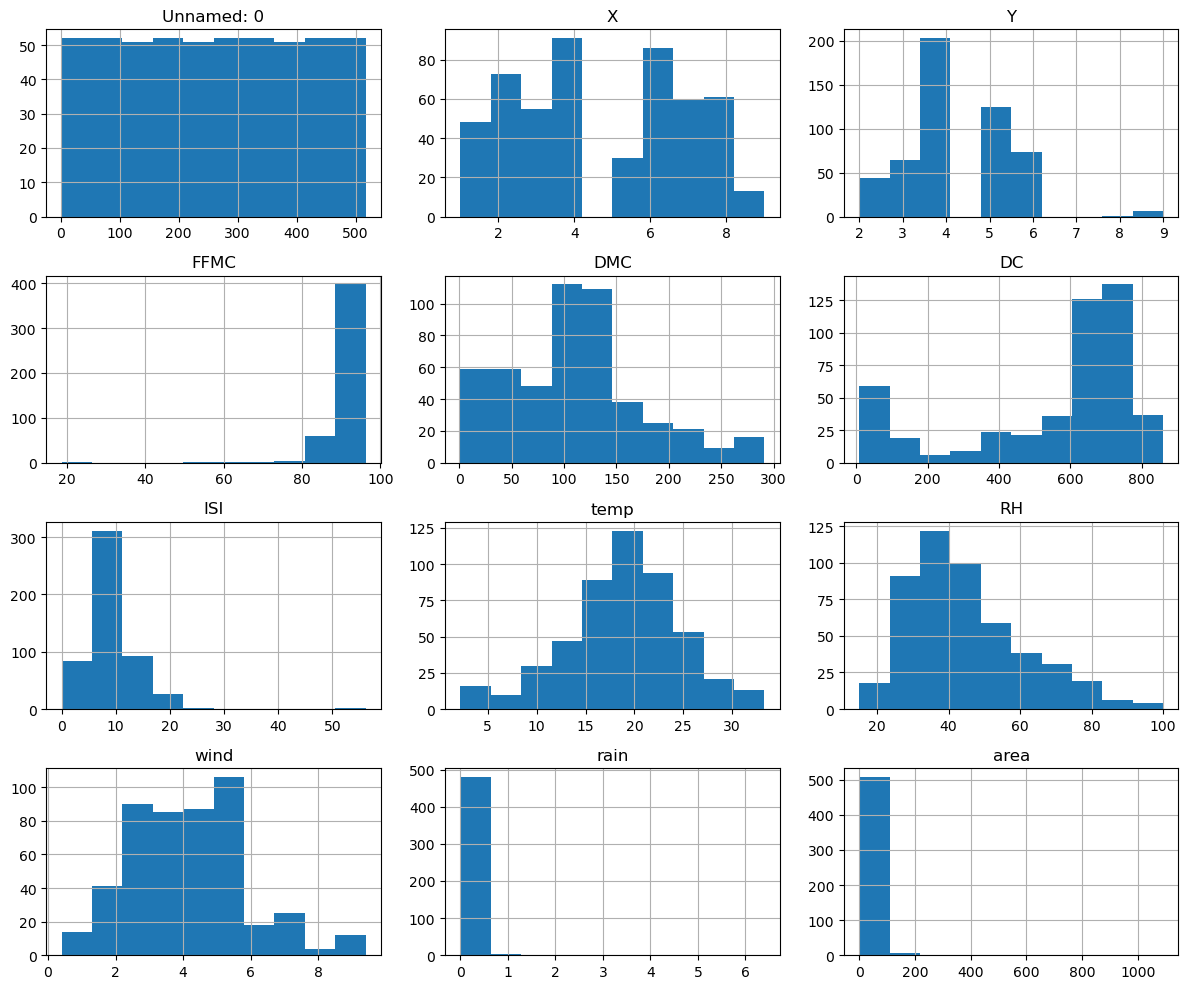

In [7]:
#Display the hitogram
fires.hist(figsize = (12, 10))
plt.tight_layout()
plt.show()

<AxesSubplot:>

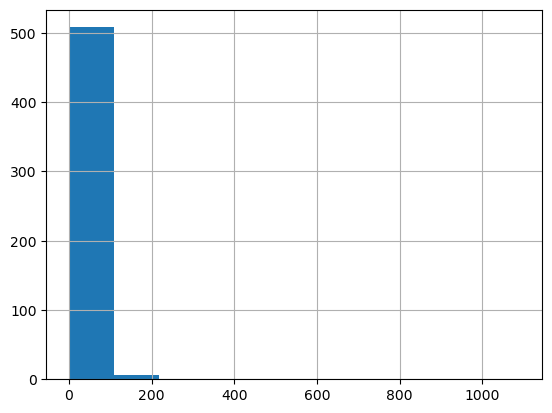

In [8]:
fires['area'].hist()

The output looks highly skewed to the left. we will log transform the data. Note since that some of the outcomes are actually zero, we can add 1 to prevent any errors.

array([[<AxesSubplot:title={'center':'log_area'}>]], dtype=object)

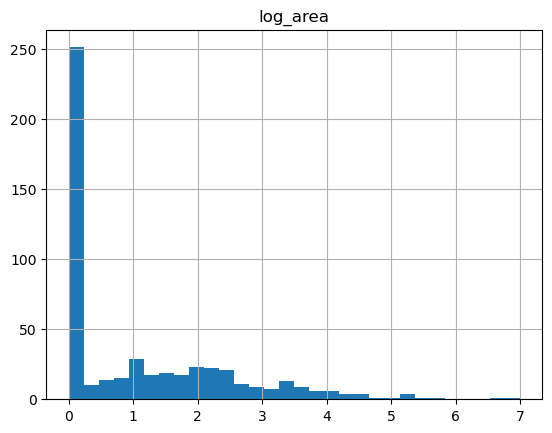

In [9]:
fires['log_area'] = np.log(fires['area'] + 1)
fires.hist("log_area", bins = 30 )

#### Data Transformation

In [10]:
#value count for column month
fires['month'].value_counts()

aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
apr      9
dec      9
jan      2
may      2
nov      1
Name: month, dtype: int64

In [11]:
#value count for column day
fires['day'].value_counts()

sun    95
fri    85
sat    84
mon    74
tue    64
thu    61
wed    54
Name: day, dtype: int64

In [12]:
#convert month and day columns to numeric
month_dict = {'jan':1, 'feb':2,'mar':3, 'apr':4, 'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}
day_dict = {'mon':1,'tue':2,'wed':3,'thu':4,'fri':5,'sat':6,'sun':7}

In [13]:
fires['month'] = fires['month'].map(month_dict)
fires['day'] = fires['day'].map(day_dict)

In [14]:
print(fires.month.dtype)
print(fires.day.dtype)

int64
int64


#### Imputation

In [15]:
fire_new = fires.drop(['area','Unnamed: 0', 'log_area'],axis = 1)
imp = SimpleImputer(missing_values = np.nan, strategy = 'mean')
imp_df = imp.fit_transform(fire_new)

#convert the output to a dataframe
fires_df = pd.DataFrame(imp_df, columns = fire_new.columns)

In [16]:
fires_df.head(3)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,7.0,5.0,3.0,5.0,86.2,26.200000,94.300000,5.1,18.884677,51.0,6.7,0.0
1,7.0,4.0,10.0,2.0,90.6,111.195363,669.100000,6.7,18.000000,33.0,0.9,0.0
2,7.0,4.0,10.0,6.0,90.6,43.700000,550.673418,6.7,14.600000,33.0,1.3,0.0


In [17]:
#Check the null values
fires_df.isnull().sum()

X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
dtype: int64

#### Handling outliers

<AxesSubplot:>

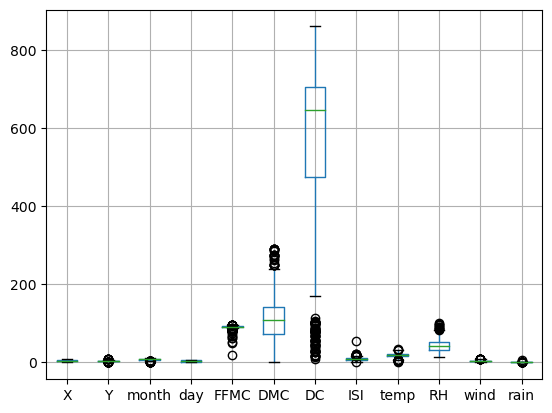

In [18]:
fires_df.boxplot(column = ['X','Y','month','day','FFMC','DMC','DC','ISI','temp','RH','wind','rain'])

From the above we can see there is some outliers, we will calculate the outliers

In [19]:
for col in fires_df:
    quartiles = np.percentile(fires_df[col],[25, 50, 75])
    iqr = quartiles[2] - quartiles[0]
    lower_bound = quartiles[0] - (1.5 * iqr)
    upper_bound = quartiles[2] + (1.5 * iqr)
    num_outliers = sum((fires_df[col] < lower_bound) | (fires_df[col] > upper_bound))
    
    print(f'The {col} column has {num_outliers} outliers according to the boxplot method')   

The X column has 0 outliers according to the boxplot method
The Y column has 51 outliers according to the boxplot method
The month column has 76 outliers according to the boxplot method
The day column has 0 outliers according to the boxplot method
The FFMC column has 68 outliers according to the boxplot method
The DMC column has 22 outliers according to the boxplot method
The DC column has 77 outliers according to the boxplot method
The ISI column has 23 outliers according to the boxplot method
The temp column has 20 outliers according to the boxplot method
The RH column has 10 outliers according to the boxplot method
The wind column has 12 outliers according to the boxplot method
The rain column has 40 outliers according to the boxplot method


From the above we can see there is some outliers. We will use KNN imputation and calculate the outliers again.

In [20]:
#using KNN Imputer
imp = KNNImputer(missing_values = np.nan, n_neighbors = 3)
knn_imputed = imp.fit_transform(fire_new)
fire_knn_df = pd.DataFrame(knn_imputed, columns = fire_new.columns)

In [21]:
#calculate the outliers
for col in fire_knn_df:
    quartiles = np.percentile(fire_knn_df[col], [0,25,75])
    iqr = quartiles[2] - quartiles[0]
    lower_bound = quartiles[0] - (1.5 * iqr)
    upper_bound = quartiles[2] + (1.5 * iqr)
    outliers = sum((fire_knn_df[col] < lower_bound) | (fire_knn_df[col] > upper_bound))
    
    print(f'The {col} column has {outliers} outliers in the dataset')
    

The X column has 0 outliers in the dataset
The Y column has 0 outliers in the dataset
The month column has 0 outliers in the dataset
The day column has 0 outliers in the dataset
The FFMC column has 0 outliers in the dataset
The DMC column has 0 outliers in the dataset
The DC column has 0 outliers in the dataset
The ISI column has 1 outliers in the dataset
The temp column has 0 outliers in the dataset
The RH column has 0 outliers in the dataset
The wind column has 0 outliers in the dataset
The rain column has 8 outliers in the dataset


In [22]:
#Now we will standadize the data
scaler = StandardScaler()
scaled = scaler.fit_transform(fire_knn_df)
scaled = pd.DataFrame(scaled, columns = fire_knn_df.columns)

final_df = scaled.copy()
final_df.head(3)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,1.008313,0.569860,-1.968443,0.357721,-0.812861,-1.334681,-1.849500,-0.860187,-0.406562,0.425177,1.515212,-0.073268
1,1.008313,-0.244001,1.110120,-1.090909,-0.010894,-0.746036,0.493285,-0.508736,-0.162787,-0.709197,-1.757506,-0.073268
2,1.008313,-0.244001,1.110120,0.840597,-0.010894,-1.059245,0.548309,-0.508736,-0.754813,-0.709197,-1.531801,-0.073268


### Subset Selection

In [23]:
y = fires['log_area']

sfs_model = LinearRegression()
sfs_model2 = LinearRegression()
sfs_model3 = LinearRegression()

forward2 = SequentialFeatureSelector(estimator = sfs_model , n_features_to_select = 2, direction = 'forward')
forward4 = SequentialFeatureSelector(estimator = sfs_model2 , n_features_to_select = 4, direction = 'forward')
forward6 = SequentialFeatureSelector(estimator = sfs_model3 , n_features_to_select = 6, direction = 'forward')

forward2.fit(final_df, y)
forward4.fit(final_df, y)
forward6.fit(final_df, y)

print('Features selected in feature 2 model is:',forward2.get_feature_names_out())
print('Features selected in feature 4 model is:',forward4.get_feature_names_out())
print('Features selected in feature 6 model is:',forward6.get_feature_names_out())

Features selected in feature 2 model is: ['X' 'month']
Features selected in feature 4 model is: ['X' 'month' 'FFMC' 'wind']
Features selected in feature 6 model is: ['X' 'month' 'day' 'FFMC' 'RH' 'wind']


In [24]:
backward2 = SequentialFeatureSelector(estimator = sfs_model , n_features_to_select = 2, direction = 'backward')
backward4 = SequentialFeatureSelector(estimator = sfs_model , n_features_to_select = 4, direction = 'backward')
backward6 = SequentialFeatureSelector(estimator = sfs_model , n_features_to_select = 6, direction = 'backward')

backward2.fit(final_df, y)
backward4.fit(final_df, y)
backward6.fit(final_df, y)

print('Features selected in feature 2 model is:',backward2.get_feature_names_out())
print('Features selected in feature 4 model is:',backward4.get_feature_names_out())
print('Features selected in feature 6 model is:',backward6.get_feature_names_out())

Features selected in feature 2 model is: ['X' 'DC']
Features selected in feature 4 model is: ['X' 'FFMC' 'DC' 'wind']
Features selected in feature 6 model is: ['X' 'day' 'FFMC' 'DC' 'RH' 'wind']


from the above we can see that the columns X, wind, FFMC seems to be the the columns which could the predict the area.

In [25]:
fw2_model = LinearRegression()
fw4_model = LinearRegression()
fw6_model = LinearRegression()

bw2_model = LinearRegression()
bw4_model = LinearRegression()
bw6_model = LinearRegression()

### More Candidate Models

In [26]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(alphas = np.linspace(1, 10000, num=1000))
lasso = LassoCV(alphas = np.linspace(1, 10000, num=1000))

ridge.fit(final_df, y)
lasso.fit(final_df, y)

print("Ridge tuning parameter: ", ridge.alpha_)
print("LASSO tuning parameter: ", lasso.alpha_)

print("Ridge coefficients: ", ridge.coef_)
print("LASSO coefficients: ", lasso.coef_)

Ridge tuning parameter:  1312.1801801801803
LASSO tuning parameter:  10000.0
Ridge coefficients:  [ 0.02405061  0.01321725  0.03897012  0.00083947  0.01148302  0.01792328
  0.01355345 -0.01261413  0.0093364  -0.0177411   0.02666696  0.00790259]
LASSO coefficients:  [ 0.  0.  0.  0.  0.  0.  0. -0.  0. -0.  0.  0.]


In [27]:
ridge = RidgeCV(alphas = np.linspace(1000, 1500, num=1000))
ridge.fit(final_df, y)
print("Ridge tuning parameter: ", ridge.alpha_)

Ridge tuning parameter:  1311.3113113113113


### K-Fold Cross-Validation

In [28]:
from sklearn.model_selection import cross_val_score
reference = LinearRegression()
reference_cv = cross_val_score(reference, final_df[['wind','temp']], y, cv = 5, scoring = "neg_mean_squared_error")
fw2_cv = cross_val_score(fw2_model,final_df[forward2.get_feature_names_out()],y,cv = 5, scoring = "neg_mean_squared_error")
fw4_cv = cross_val_score(fw4_model,final_df[forward4.get_feature_names_out()],y,cv = 5, scoring = "neg_mean_squared_error")
fw6_cv = cross_val_score(fw6_model,final_df[forward6.get_feature_names_out()],y,cv = 5, scoring = "neg_mean_squared_error")
bw2_cv = cross_val_score(bw2_model,final_df[backward2.get_feature_names_out()],y,cv = 5, scoring = "neg_mean_squared_error")
bw4_cv = cross_val_score(bw4_model,final_df[backward4.get_feature_names_out()],y,cv = 5, scoring = "neg_mean_squared_error")
bw6_cv = cross_val_score(bw6_model,final_df[backward6.get_feature_names_out()],y,cv = 5, scoring = "neg_mean_squared_error")

ridge_cv = cross_val_score(ridge, final_df, y, cv = 5, scoring = "neg_mean_squared_error")

In [29]:
print("Reference Model, Average Test MSE: ", np.mean(reference_cv), " SD: ", np.std(reference_cv))
print("Forward-2 Model, Average Test MSE: ", np.mean(fw2_cv), " SD: ", np.std(fw2_cv))
print("Forward-4 Model, Average Test MSE: ", np.mean(fw4_cv), " SD: ", np.std(fw4_cv))
print("Forward-6 Model, Average Test MSE: ", np.mean(fw6_cv), " SD: ", np.std(fw6_cv))
print("Backward-2 Model, Average Test MSE: ", np.mean(bw2_cv), " SD: ", np.std(bw2_cv))
print("Backward-4 Model, Average Test MSE: ", np.mean(bw4_cv), " SD: ", np.std(bw4_cv))
print("Backward-6 Model, Average Test MSE: ", np.mean(bw6_cv), " SD: ", np.std(bw6_cv))
print("Ridge Model, Average Test MSE: ", np.mean(bw6_cv), " SD: ", np.std(bw6_cv))

Reference Model, Average Test MSE:  -2.2068857615497146  SD:  1.0617062096101075
Forward-2 Model, Average Test MSE:  -2.161782595453161  SD:  0.9917131932776126
Forward-4 Model, Average Test MSE:  -2.164106836590128  SD:  0.9788837522851868
Forward-6 Model, Average Test MSE:  -2.189774539136042  SD:  0.9793016035110148
Backward-2 Model, Average Test MSE:  -2.16879641228092  SD:  1.022212284267364
Backward-4 Model, Average Test MSE:  -2.1688083895987216  SD:  1.0026266173196383
Backward-6 Model, Average Test MSE:  -2.192888902547586  SD:  0.9997469989928984
Ridge Model, Average Test MSE:  -2.192888902547586  SD:  0.9997469989928984
